In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [8]:
data_dir = '../input/gtsrb-german-traffic-sign/'
train_path = '../input/gtsrb-german-traffic-sign/Train/'
test_path = '../input/gtsrb-german-traffic-sign/Test/'
height = 50
width = 50


In [10]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [13]:
batch_size = 4
seed = 42


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


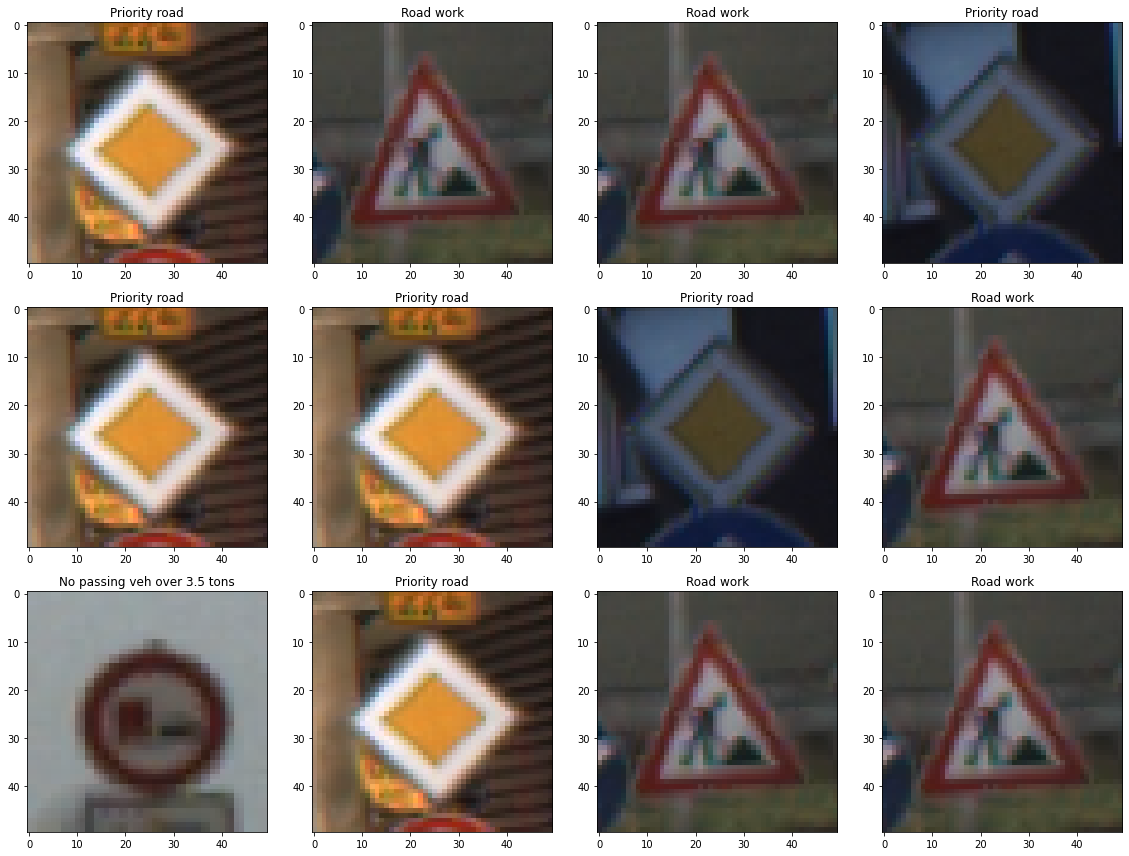

In [7]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [8]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Dense(43, activation='softmax')
])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [10]:
alpha=0.0001
epochs=30
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [11]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))


Epoch 1/30
7842/7842 [==============================] - 200s 24ms/step - loss: 0.9767 - accuracy: 0.7483 - val_loss: 0.2091 - val_accuracy: 0.9410
Epoch 2/30
7842/7842 [==============================] - 59s 8ms/step - loss: 0.1924 - accuracy: 0.9488 - val_loss: 0.1437 - val_accuracy: 0.9596
Epoch 3/30
7842/7842 [==============================] - 60s 8ms/step - loss: 0.1161 - accuracy: 0.9693 - val_loss: 0.1275 - val_accuracy: 0.9654
Epoch 4/30
7842/7842 [==============================] - 60s 8ms/step - loss: 0.0708 - accuracy: 0.9812 - val_loss: 0.0988 - val_accuracy: 0.9713
Epoch 6/30
7842/7842 [==============================] - 59s 8ms/step - loss: 0.0576 - accuracy: 0.9844 - val_loss: 0.0780 - val_accuracy: 0.9756
Epoch 7/30
7842/7842 [==============================] - 58s 7ms/step - loss: 0.0485 - accuracy: 0.9866 - val_loss: 0.0776 - val_accuracy: 0.9776
Epoch 8/30
7842/7842 [==============================] - 58s 7ms/step - loss: 0.0408 - accuracy: 0.9891 - val_loss: 0.0833 - val_

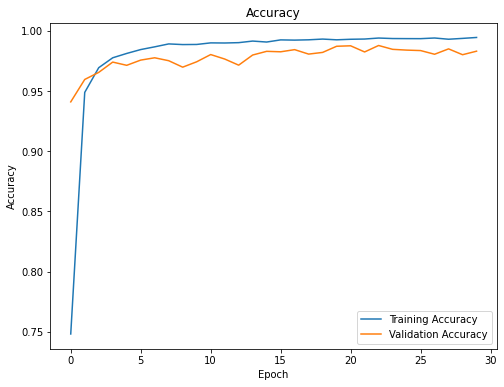

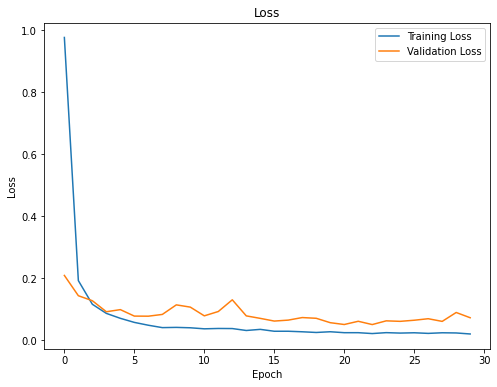

In [12]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save("CNN.h5")

In [14]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + 'Test.csv')

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [15]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  93.34916864608076


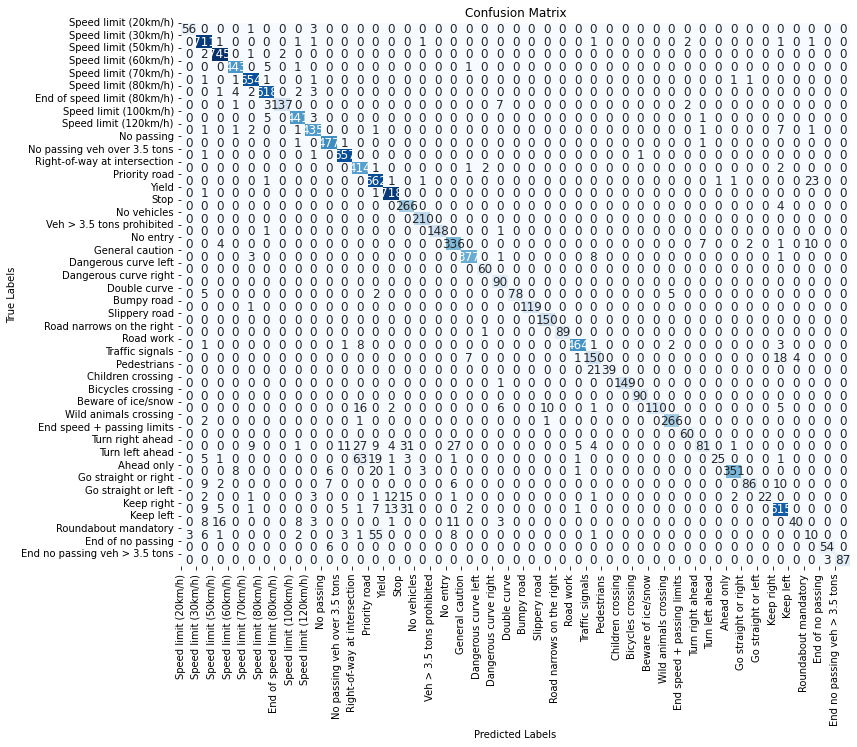

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 12})  # Adjust the font size for the prediction numbers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(classes)), classes.values(), rotation=90)
plt.yticks(np.arange(len(classes)), classes.values())
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Reset the test dataset generator
test_dataset.reset()

# Predict labels for the test dataset
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels for the test dataset
true_labels = test_dataset.classes

# Calculate Metrics (F1-score, Recall, Precision) for Test Dataset
report = classification_report(true_labels, y_pred, target_names=classes.values(), output_dict=True)
f1_score = report["weighted avg"]["f1-score"] * 100
precision = report["weighted avg"]["precision"] * 100
recall = report["weighted avg"]["recall"] * 100

print("F1 Score: {:.2f}%".format(f1_score))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))

F1 Score: 3.80%
Precision: 3.80%
Recall: 3.81%


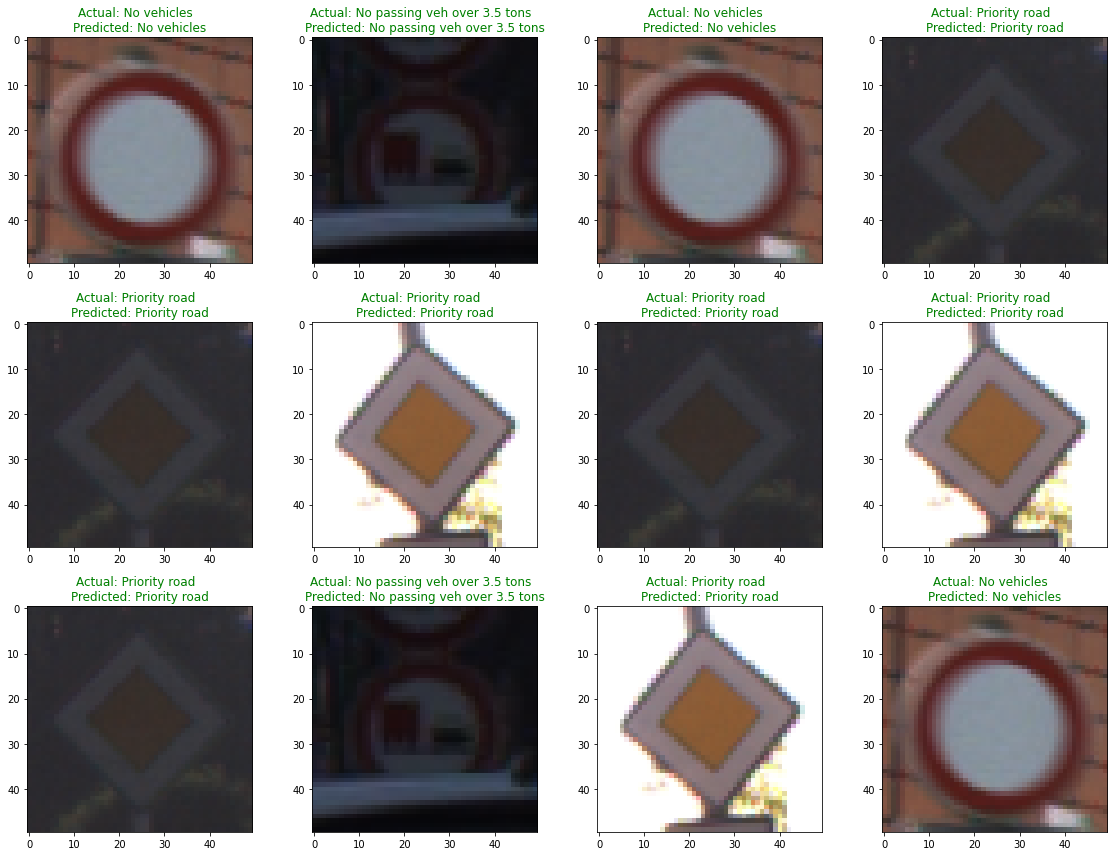

In [26]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()